# SNIP Fit Analysis
**In this notebook, we use the fits computed from Pymca's SNIP tool to analyze 1) Which angle and detector combination allows for the cleanest HfO2 spectrum to be obtained, and 2) Which SNIP parameters allow for the cleanest removal of diffraction peaks/background radiation while preserving the Hf counts.**

*Date: 07/11/2024*

*Author: Sonia Ghoshal, NIST SURF*

## Table of Contents: 

1.1 Setup 

1.2 Imports

1.3 .fit File Reading

2.1 Which Angle is Best?

    A. Reading the Hf L counts 
    B. Examining the principal peak counts for various angles and thicknesses
    C. Analysis of best angle

2.3 Visualizing the L2 and L3 Peak Fits ***move this section up after "Which Angle is the Best"**


3.0 Visualizing the Hf Spectrum

    A. Plotting the 6nm HfO2 Spectrum, its pymca fit, and the continuum
    B. Zoomed in Graph

4.0 Removing Background Radiation 

    A. Subtracting continuum from spectrum
    B. Plotting the continuum models under various SNIP widths
    C. Plotting the "cleaned up" (continuum-removed) signals under various SNIP widths

5.0 Which SNIP Width is the Best?



--------------------------------------------------------------------------------------------------------------------------------------------------------


## 1.1 Setup
### Chip Details:
* type: KRISS K157 #502
* thicknesses: 6.0nm, 3.0nm, 2.0nm HfO2
* composition: HfO2 nanofilm over Si substrate
### Experiment summary: 
* initially took mXRF scans at rotations of angles 0, 10, 20, 30, 40, 50, 60, 70, 80, 90
* each measurement consisted of 10 Detector 1 (D1) scans and 10 Detector 2 (D2) scans
* observed that angle 40 and D1 scans allowed for the best isolation of Hf peaks
* took measurements at angles 32, 34, 36, 38, 40, 42, 44, 46, 48
* angle 40 once again seemed to be the best angle
* Here, we use the 9th D1 scan (D1_8) for consistency, but eventually we want to average all of the D1 scans at angle 40
* path to data: C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\raw\20240626_K157_6nm_Rotation\40_deg\20240626_K157_6nm_Rotation_40_deg_repeat_Rh_FE_D1_0_8.spx

## 1.2 Imports

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

## 1.3 .fit File Reading

In [3]:
def readFitFile(path):
    fit = open(path)

    #ignore the [info] section. We only care about [results] section
    line = fit.readline()
    while("result") not in line:
       line = fit.readline()

    # there is a space between every number, so we split up the array by spaces
    # by doing so, we have unwanted items "xdata', "=", and "[ " in the array, which we exclude by starting at index 3
    xdata = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    energy = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    ydata = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    yfit = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    continuum = np.array(fit.readline().split(" ")[3:-1], dtype=float)

    fit.close()
    
    return xdata, energy, ydata, yfit, continuum

In [4]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_6nm_Rotation_40_D1_Fit1\\")
data = {}
for i in ["5", "10", "20", "30", "45", "60"]:
    data[i] = readFitFile(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])


**Summary:**
Now, we have collected the data from a 40 degrees .fit file and arranged it in a 4D array. We will use this data as an example to illustrate features of the HfO2 film spectra throughout this notebook. 

The first index (String type) corresponds to the thickness, the second index (String type) corresponds to the SNIP width (5, 10, 20, 30, 45, or 60) and the third index (float type) corresponds to the type of data (xdata, energy, ydata, yfit, or continuum). 

`data['thickness']['width'][0]` gives an array of xdata (channels) 

`data['thickness']['width'][1]` gives an array of energy

`data['thickness']['width'][2]` gives an array of ydata coordinates

`data['thickness']['width'][3]` gives an array of yfit coordinates

`data['thickness']['width'][4]` gives an array of continuum (y-coordinates)


## 2.1 Which Angle is the Best?
**In this section, we use the .fit file data to calculate the area under the curve of the principal peak of Hf (L3). We calculate this area for the original spectra and all of the "cleaned" spectra with varying SNIP widths. We undergo these calculations for wafers of different thicknesses (6.0nm, 3.0nm, 2.0nm), and observe whether the calculated principal peak counts are proportional to the thicknesses of the wafers.**

#### 2.1.1: Reading the Hf L-peaks counts

In [6]:
def readPeakCounts(path): 
    fit = open(path)
    
    #ignore the [info] section. We only care about [results] section
    line = fit.readline()
    while("yHf L") not in line:
        line = fit.readline()
    # there is a space between every number, so we split up the array by spaces
    # by doing so, we have unwanted items "yHf", "L", "=", and "[" in the array, which we exclude by starting at index 4
    yHf_L = np.array(line.split(" ")[4:-1], dtype=float)
    yHf_L1 = np.array(fit.readline().split(" ")[4:-1], dtype=float)
    yHf_L2 = np.array(fit.readline().split(" ")[4:-1], dtype=float)
    yHf_L3 = np.array(fit.readline().split(" ")[4:-1], dtype=float)

    fit.close()
    
    return yHf_L, yHf_L1, yHf_L2, yHf_L3
    

#### 2.1.2: Visualizing Hf Principal Peak Fits

##### We use a 40 degree 6nm scan as an example to visualize the Hf peaks.

In [7]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_6nm_Rotation_40_D1_Fit1\\")
data_peaks = {}
for i in ["5", "10", "20", "30", "45", "60"]:
    data_peaks[i] = readPeakCounts(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

In [8]:
# Establishing the "viridis" colormap for data visuals
cmap = plt.colormaps.get_cmap('viridis')

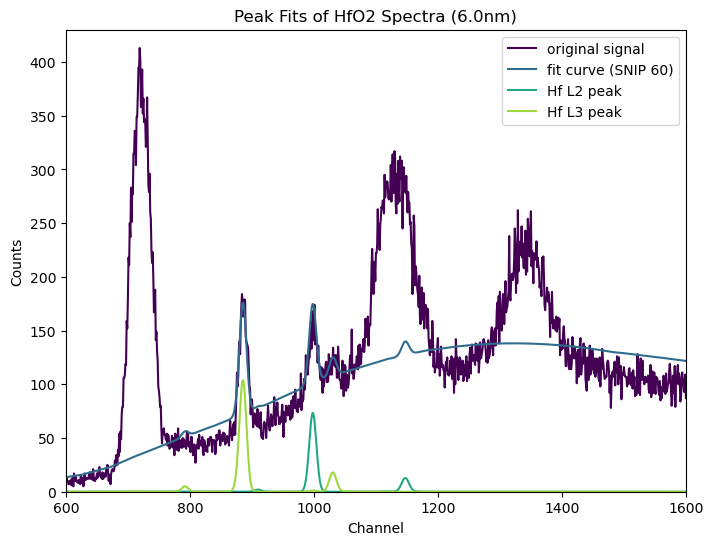

In [45]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 430)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["60"][0], data["60"][3], color = cmap(0.35), label = "fit curve (SNIP 60)")
#ax.plot(data["60"][0], data_peaks["60"][0], color = 'r', label= "yHf L peaks")
#ax.plot(data["60"][0], data_peaks["60"][1], color = 'g', label= "yHf L1 peaks")
ax.plot(data["60"][0], data_peaks["60"][2], color = cmap(0.6), label= "Hf L2 peak")
ax.plot(data["60"][0], data_peaks["60"][3], color = cmap(0.85), label= "Hf L3 peak")

ax.set_title("Peak Fits of HfO2 Spectra (6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
ax.legend()

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("Peak_Fits_HfO2_6nm_Rot40_SNIP60")

plt.show()

#### 2.1.3: Examining the principal peak Hf counts for various angles and thicknesses
##### We look at the L3 peaks of Hf for angles 38-46 in 2 degree increments for 2nm, 3nm, and 6nm thicknesses. Prior, we have examined that these angles allow for the best separation of fluorescence peaks and background scattering, except for 38 degrees which we keep as an example of diffraction interference. We compare the counts from Pymca and Bruker. 

**PYMCA (SNIP width 60):**

In [36]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\all_fits\\")

#the peak_L3 array contains the y-coordinates Hf L3 peak for all three thicknesses at angles 38, 40, 42, 44, 45, and 46 and detector 1 and 2
peak_L3 = {}
for i in ['2', '3', '6']:
    peak_L3[i] = {}
    for j in ['38', '40', '42', '44', '45', '46']: 
        peak_L3[i][j] = {}
        for k in ['1', '2']: 
            peak_L3[i][j][k] = readPeakCounts(glob.glob("2024*_K157_" + i + "nm_Rotation_" + j + "_deg_repeat_Rh_FE_D" + k + 
                                                         "*.fit")[0])[2]

#the peak_sums array contains the sum of the y-coordinates (basically area under the curve) for the Hf principal peak (L3)
peak_sums = {}
for i in ['38', '40', '42', '44', '45', '46']: 
    for j in ['1', '2']: 
        peak_sums[i +'deg D' + j] = [peak_L3['2'][i][j].sum(), peak_L3['3'][i][j].sum(), peak_L3['6'][i][j].sum()]


peak_sums_df = pd.DataFrame(data = peak_sums, index = ['2nm', '3nm', '6nm'])
peak_sums_df

,38deg D1,38deg D2,40deg D1,40deg D2,42deg D1,42deg D2,44deg D1,44deg D2,45deg D1,45deg D2,46deg D1,46deg D2
2nm,393.998615,432.333247,356.611795,395.395655,287.529793,295.925301,141.960097,208.565184,452.355711,473.935767,326.681710,541.427621
3nm,638.721606,476.044957,568.803496,475.336784,521.536038,630.489801,823.155714,475.265583,430.786215,649.555361,536.258923,667.398852
6nm,1307.441207,1238.383081,1291.367755,1216.845376,1157.379671,1460.691558,1053.514999,971.442972,1391.390495,1143.900771,1328.890837,1163.143170


**BRUKER:**

In [46]:
# AVERAGES:
bruker_data = {
    '38deg D1': np.array([945, 1998, 4067]),
    '38deg D2': np.array([3431, 2232, 4489]), # high diffraction evident in 2nm scan
    '40deg D1': np.array([1174, 1981, 3949]), 
    '40deg D2': np.array([1408, 2180, 4440]),
    '42deg D1': np.array([1200, 2010, 3974]),
    '42deg D2': np.array([1270, 2124, 4172]),
    '44deg D1': np.array([1242, 2144, 3956]),
    '44deg D2': np.array([1227, 1970, 4076]),
    '45deg D1': np.array([1293, 2142, 3927]),
    '45deg D2': np.array([1230, 1920, 3975]),
    '46deg D1': np.array([1369, 2208, 3956]),
    '46deg D2': np.array([1261, 1955, 4079])
}

bruker_df = pd.DataFrame(data = bruker_data, index = ['2nm', '3nm', '6nm'])

#### 2.1.4:  Plotting the net counts recorded for each of the 2nm, 3nm, and 6nm thicknesses
##### Here, we examine how the thickness of the HfO2 films affects how many net counts of Hf are recorded. We expect the number of net counts to go up linearly with the thickness, but in cases with prominent diffraction interefering with the peaks (i.e. 38$\degree$), the net counts recorded is artifically inflated particularly for the lowest thickness of 2nm, disrupting the linear trendlines. We examine how the trendlines, particularly its a) correlation to the data points and b) its x-intercept, vary based on the angle measured.  

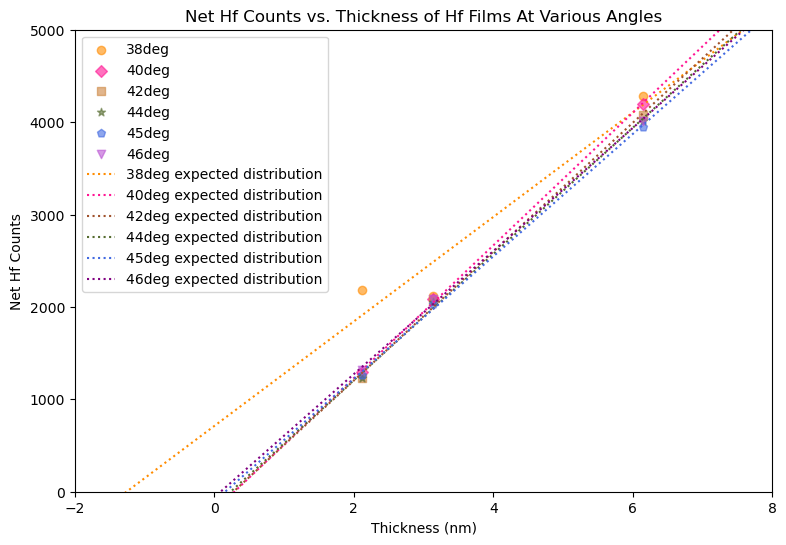

,r
38deg,0.962081
40deg,0.999809
42deg,0.999092
44deg,0.998970
45deg,0.999390
46deg,0.999481


,x-intercepts
38deg,-1.258133
40deg,0.288806
42deg,0.275574
44deg,0.234111
45deg,0.155188
46deg,0.090171


In [97]:
fig, ax = plt.subplots(figsize = (9,6))
ax.set_xlim(-2, 8)
ax.set_ylim(0, 5000)

thicknesses = [2.12, 3.14, 6.14] # exact thicknesses
x_ints = []
coor_coeffs = []

# Plot average of D1 and D2 scans for angles 38, 40, 42, 44, 45, 46

plt.scatter(thicknesses, (bruker_data['38deg D1'] + bruker_data['38deg D2'])/2, c = 'darkorange', marker = 'o', alpha = 0.6, label = '38deg')
plt.scatter(thicknesses, (bruker_data['40deg D1'] + bruker_data['40deg D2'])/2, c = 'deeppink', marker = 'D', alpha = 0.6, label = '40deg')
plt.scatter(thicknesses, (bruker_data['42deg D1'] + bruker_data['42deg D2'])/2, c = 'peru', marker = 's', alpha = 0.6, label = '42deg')
plt.scatter(thicknesses, (bruker_data['44deg D1'] + bruker_data['44deg D2'])/2, c = 'darkolivegreen', marker = '*', alpha = 0.6, label = '44deg')
plt.scatter(thicknesses, (bruker_data['45deg D1'] + bruker_data['45deg D2'])/2, c = 'royalblue', marker = 'p', alpha = 0.6, label = '45deg')
plt.scatter(thicknesses, (bruker_data['46deg D1'] + bruker_data['46deg D2'])/2, c = 'mediumorchid', marker = 'v', alpha = 0.6, label = '46deg')

# Plot lines of best fit for angles 38, 40, 42, 44, 45, 46

x = np.linspace(-10, 10, 50)

a, b = np.polyfit(thicknesses, ((bruker_data['38deg D1'] + bruker_data['38deg D2'])/2), 1)
plt.plot(x, a*(x) + b, c = 'darkorange', linestyle = ':', label = '38deg expected distribution')
x_ints.append(-b/a)
coor_coeffs.append((np.corrcoef(thicknesses, ((bruker_data['38deg D1'] + bruker_data['38deg D2'])/2)))[0,1])

a, b = np.polyfit(thicknesses, ((bruker_data['40deg D1'] + bruker_data['40deg D2'])/2), 1)
plt.plot(x, a*(x) + b, c = 'deeppink', linestyle = ':', label = '40deg expected distribution')
x_ints.append(-b/a)
coor_coeffs.append((np.corrcoef(thicknesses, ((bruker_data['40deg D1'] + bruker_data['40deg D2'])/2)))[0,1])

a, b = np.polyfit(thicknesses, ((bruker_data['42deg D1'] + bruker_data['42deg D2'])/2), 1)
plt.plot(x, a*(x) + b, c = 'sienna', linestyle = ':', label = '42deg expected distribution')
x_ints.append(-b/a)
coor_coeffs.append((np.corrcoef(thicknesses, ((bruker_data['42deg D1'] + bruker_data['42deg D2'])/2)))[0,1])

a, b = np.polyfit(thicknesses, ((bruker_data['44deg D1'] + bruker_data['44deg D2'])/2), 1)
plt.plot(x, a*(x) + b, c = 'darkolivegreen', linestyle = ':', label = '44deg expected distribution')
x_ints.append(-b/a)
coor_coeffs.append((np.corrcoef(thicknesses, ((bruker_data['44deg D1'] + bruker_data['44deg D2'])/2)))[0,1])

a, b = np.polyfit(thicknesses, ((bruker_data['45deg D1'] + bruker_data['45deg D2'])/2), 1)
plt.plot(x, a*(x) + b, c = 'royalblue', linestyle = ':', label = '45deg expected distribution')
x_ints.append(-b/a)
coor_coeffs.append((np.corrcoef(thicknesses, ((bruker_data['45deg D1'] + bruker_data['45deg D2'])/2)))[0,1])

a, b = np.polyfit(thicknesses, ((bruker_data['46deg D1'] + bruker_data['46deg D2'])/2), 1)
plt.plot(x, a*(x) + b, c = 'purple', linestyle = ':', label = '46deg expected distribution')
x_ints.append(-b/a)
coor_coeffs.append((np.corrcoef(thicknesses, ((bruker_data['46deg D1'] + bruker_data['46deg D2'])/2)))[0,1])

ax.set_title("Net Hf Counts vs. Thickness of Hf Films At Various Angles")
ax.set_xlabel("Thickness (nm)")
ax.set_ylabel("Net Hf Counts")
plt.legend()

# os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
# plt.savefig("NetHfCounts_v_Thickness_Graph")

labels = ['38deg', '40deg', '42deg', '44deg', '45deg', '46deg']
coor_coeffs_df = pd.DataFrame(coor_coeffs, index = labels, columns = ['r'])
x_ints_df = pd.DataFrame(x_ints, index = labels, columns = ['x-intercepts'])

plt.show()
display(coor_coeffs_df)
display(x_ints_df)


#### 2.1.5 Analyzing which angles consistently yielded the strongest signal
**Analysis:**
To determine the best angle, we examine the 1) correlations and 2) x-intercepts of the trendlines shown above.

**(1)**
We see that 40$\degree$ , 42$\degree$ , 44$\degree$ , 45$\degree$ , and 46$\degree$ are all acceptable angles that closely follow linear models. The correlation coefficient is We see that 38$\degree$ 2nm measurement is inflated due to the strong diffraction that overlaps with a Hf peak, which is particularly evident in the 2nm measurement. This observation is reflected in the correlation coefficients, which are all ~0.999 except for the 38deg line, which is ~0.96.

**(2)**
The x-intercepts ideally indicate the thinnest film that could be measured. In reality, the thinnest film able to be measured is ~0.5nm, which is far higher than any of the x-intercepts calculated above. However, the 40$\degree$  scan comes closest to that number. Thus, it seems that the 40$\degree$  orientation is a safe bet for both its correlation and x-intercept. 

**Caveat:**
We don't have nearly enough data to extrapolate the conclusion that 40 degrees is definitely the best orientation to measure HfO2 films in. We need more thickness measurements (we only have 3) and repeated trials (10 per angle/thickness) to conclusively determine the best angle. However, for the purposes of this study, we assume based on our data collected that 40 degrees is presumptively the most preferable angle. 


## 2.3 Plotting the Fits

#### A. Plotting the 6nm HfO2 spectra, its fit curve from pymca, and the continuum (background radiation)

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 0, xmax = 2700)
ax.set_ylim(ymin = 0, ymax = 700)

# ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
# ax.plot(data["60"][0], data["60"][3], color = cmap(0.55), label = "fit curve (SNIP 60)" )
# ax.plot(data["60"][0],data["60"][4], color = cmap(0.85), label = "background (SNIP 60)")

ax.plot(avg_45D2[0], avg_45D2[2], color = cmap(0), label = "original signal")
ax.plot(avg_45D2[0], avg_45D2[3], color = cmap(0.55), label = "fit curve (SNIP 60)")
ax.plot(avg_45D2[0], avg_45D2[4], color = cmap(0.85), label = "background")


ax.legend()
ax.set_title("HfO2 mXRF Spectra Fit (45deg 6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("HfO2_Spectra_SNIP60_40deg")

plt.show()

In [110]:
# Example: average of fits for 6nm, angle 45, D2
## Assume naming convention consistent with our files

thickness = '6'
angle = '45'
detector = '2'
num_of_files = 10
batch = 'K157'
path = "C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\" + batch + "_Rotation_" + angle + '_D' + detector + "_Fits"

os.chdir(path)

rot_fits = {} # will contain the xdata, energy, ydata, yfit, continuum data for each scan 

for i in range (num_of_files): 
    rot_fits[i] = readFitFile(glob.glob("*_" + batch + "_" + thickness + "nm_Rotation_" + angle + "_deg_repeat_Rh_FE_D" + detector + "_0_" + str(i) + 
                                                         "*.fit")[0])
avg_fits = {} # will contain the average arrays for each of the xdata, energy, ydata, yfit, and continuum arrays
sum = 0
for k in range (5):
    avg_fits[k] = np.zeros(len(rot_fits[0][0]))
    for j in range (len(rot_fits[0][0])):
        for i in range (10):
            sum += rot_fits[i][k][j]
        sum = sum / 10
        avg_fits[k][j] = sum
        sum = 0

avg_fits

{0: array([  69.,   70.,   71., ..., 2698., 2699., 2700.]),
 1: array([-0.27493098, -0.26491615, -0.25490133, ..., 26.05403946,
        26.06405428, 26.0740691 ]),
 2: array([0.7, 1.1, 1.4, ..., 9. , 9. , 9.9]),
 3: array([-1.70981654, -1.63128549, -1.5429466 , ..., 10.40970596,
        11.29042687, 11.72152216]),
 4: array([-1.70981654, -1.63128549, -1.5429466 , ..., 10.40970596,
        11.29042687, 11.72152216])}

#### B. Zooming into the previous graph
*We separate this from the previous block of code because we want to save two different .png files*

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["60"][0], data["60"][3], color = cmap(0.55), label = "fit curve (SNIP 60)" )
#ax.plot(data["30"][0], data["30"][3], color = 'r', label = "fit curve (SNIP 30)" )
#ax.plot(data["20"][0], data["20"][3], color = 'b', label = "fit curve (SNIP 20)" )
ax.plot(data["60"][0],data["60"][4], color = cmap(0.85), label = "background (SNIP 60)")

ax.legend()
ax.set_title("Zoomed in HfO2 mXRF Spectra Fit (6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("Zoom_HfO2_Spectra_SNIP60_40deg")

plt.show()

## 3.0 Removing Background Radiation
#### A. Here, we subtract the continuum from the signal in an effort to isolate the fluorescence peaks.

In [ ]:
# subtracts the background; returns an array of the spectra counts - continuum counts
# parameters: ydata_arr is the spectra counts (ydata), cont_arr is the continuum y-values
def cleanedSignal(ydata_arr, cont_arr): 
    if(len(ydata_arr) != len(cont_arr)): 
        raise ValueError("Arrays must be same length.")
    
    subtractbg = [0] * len(ydata_arr)
    for i in range(len(ydata_arr)): 
         subtractbg[i] = ydata_arr[i] - cont_arr[i]

    return subtractbg

#### B. Plotting the background radiation calculated from various SNIP fits

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)
ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["45"][0],data["45"][4], color = cmap(0.25), label = "background (SNIP 45)")
#ax.plot(data["30"][0],data["30"][4], color = cmap(0.4), label = "background (SNIP 30)")
ax.plot(data["20"][0],data["20"][4], color = cmap(0.6), label = "background (SNIP 20)")
ax.plot(data["10"][0],data["10"][4], color = cmap(0.8), label = "background (SNIP 10)")
ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("Channel")
ax.set_title("Background Radiation of mXRF Spectra for HfO2")

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("Bg_HfO2_Spectra_SNIPs_40deg")
plt.show()

#### C. Plotting the "cleaned up" (background radiation removed) signals from various SNIP fits

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["45"][0], cleanedSignal(data["45"][2], data["45"][4]), color = cmap(0.25), label = "cleaned signal (SNIP 45)")
#ax.plot(data["30"][0], cleanedSignal(data["30"][2], data["30"][4]), color = cmap(0.5), label = "cleaned signal (SNIP 30)")
ax.plot(data["20"][0], cleanedSignal(data["20"][2], data["20"][4]), color = cmap(0.6), label = "cleaned signal (SNIP 20)")
ax.plot(data["10"][0], cleanedSignal(data["10"][2], data["10"][4]), color = cmap(0.85), label = "cleaned signal (SNIP 10)")

ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("Channel")
ax.set_title("Background-removed HfO2 Spectra (6.0nm)")

os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
plt.savefig("Noise_removed_HfO2_Spectra_SNIPs_40deg")

plt.show()

### 4.0 Which SNIP width is the best?
**In this section, we examine various SNIP widths under the best angle (determined from 2.1). Our goal is to determine which width best retains the Hf signal while balancing its computational cost. Lower SNIP widths are computationally more expensive, but tend to be more accurate in return. We want to determine which SNIP width balances these two trade-offs.**

In [42]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\SNIP_widths_comparison\\")

In [43]:
data_6nm_40_SNIPs = {}
for i in ['5', '10', '20', '30', '45','60']:
    data_6nm_40_SNIPs[i] = readPeakCounts(glob.glob('20240626_K157_6nm_Rotation_40_deg_D1_0_8_SNIP' + i + '.fit')[0])[3].sum()

df_6nm_40_SNIPs = pd.DataFrame(data = data_6nm_40_SNIPs, index = ['40 deg counts'])
df_6nm_40_SNIPs



,5,10,20,30,45,60
40 deg counts,26.902109,228.531552,529.080239,1525.143933,1954.034563,1858.649437


### 2.3 Visualizing the Peak Fits

In [ ]:
# # WORK IN PROGRESS FOR MULTIPLE FILES
# os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\")
# data_peaks = {}
# for j in [0, 1, 2]:
#     for i in ["5", "10", "20", "30", "45", "60"]:
#         data_peaks[j][i] = readPeakCounts(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

In [ ]:
#MAKE 3 arrays/lists for each thickness. Each array will have 5 indices for the 5 SNIPS, giving the sum of L3
#create a DF from these 3 lists 

# peakL3_sums = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#     peakL3_sums[i] = data_peaks[i][3].sum()

# peak_sums = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#     for j in range(3):
#         peak_sums[i][j] = data_peaks[i][j+1].sum()

# test = {'5': [1, 2, 3], 
#         '10': [4, 5, 6]}
# testdf = pd.DataFrame(data = test, index = ['test1', 'test2', 'test3'])
# testdf
#peakL3_df = pd.DataFrame(data = peakL3_sums, index = ['6.0.nm', '3.0nm', '2.0nm'])
#peakL3_df

## Extra: A Method to Average Pymca Scans
**Averaging the Bruker scans is easy, as it is built in to the software. However, there is no built-in method for averaging Pymca scans, because each scan is a different file. In this section , we build a method for averaging the y-fits contained within the .fit files for the 10 scans of 6nm angle 45 detector 2 Hf Counts.**